In [10]:
import pandas as pd
import numpy as np
from ete3 import Tree
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

import matplotlib.pyplot as plt

import os

INFO: Pandarallel will run on 20 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [11]:
do_weighted = False

relevant_features = ["partner.diversity", # shanon diversity
                     "d", # speciality index d',
                     "normalised.degree",
                     "weighted.betweenness", # centrality,
                     "weighted.closeness",
                     "hubbiness_score"]  # generality
relevant_features += [f"standardized_{f}" for f in relevant_features]

allmb_tree_path = "../../../data/trees/ALLMB.tre"
networks_dir = "../../../data/networks/all/"
species_features_paths = {"binary": "../../../data/features/plant/binary/features.csv",
                          "binarized_weighted": "../../../data/features/plant/binarized_weighted/features.csv",
                          "weighted": "../../../data/features/plant/weighted/features.csv"}

classification_path = "../../../data/ploidy_classification/plant_classification.csv"
ploidb_path = "../../../data/ploidy_classification/ploidb_by_genus_without_missing.csv"

taxonomic_data_path = "../../../data/features/taxonomic_features/net_to_pollinators_taxonomic_classification.csv"
networks_metadata_path = "../../../data/networks/all/networks_metadata.csv"


processed_data_path = f"../../../data/statistical_analysis/species_level/processed_features_with_ploidy_classification_on_{'un' if not do_weighted else ''}weighted_networks.csv"
processed_data_w_geo_path = f"../../../data/statistical_analysis/species_level/processed_features_with_ploidy_classification_and_geodata_on_{'un' if not do_weighted else ''}weighted_networks.csv"

pre_processed_tree_path = f"../../../data/statistical_analysis/species_level/unique_species_tree_on_{'un' if not do_weighted else ''}weighted_networks.nwk"
processed_tree_path = f"../../../data/statistical_analysis/species_level/species_tree_on_{'un' if not do_weighted else ''}weighted_networks.nwk"

species_list_path = f"../../../data/statistical_analysis/species_level/species_list_{'un' if not do_weighted else ''}weighted_analysis.csv"

# process data

In [12]:
allmb_tree = Tree(allmb_tree_path, format=1)
for leaf in allmb_tree.get_leaves():
    leaf.name = leaf.name.lower().replace("_", " ")

In [13]:
relevant_columns = ["Plant", "network_id"] + relevant_features
weighted_data = pd.read_csv(species_features_paths["weighted"])[relevant_columns]
weighted_data["network_type"] = "weighted"
binarized_weighted_data = pd.read_csv(species_features_paths["binarized_weighted"])[relevant_columns]
binarized_weighted_data["network_type"] = "binarized_weighted"
binary_data = pd.read_csv(species_features_paths["binary"])[relevant_columns]
binary_data["network_type"] = "binary"               
features = pd.concat([weighted_data,binarized_weighted_data,binary_data])
features["original_name"] = features.Plant.str.lower()

In [14]:
classification = pd.read_csv(classification_path).rename(columns={"conservative_is_polyploid": "is_polyploid",
                                                                 "conservative_polyploid_age": "ploidy_age"})

In [16]:
features_with_classification = features.merge(classification[["original_name", "resolved_name", "is_polyploid", "ploidy_age"]], on="original_name", how="left")
features_with_classification.set_index("original_name", inplace=True)
features_with_classification["is_polyploid"].fillna(classification.set_index("original_name")["conservative_is_polyploid_by_original"].to_dict(), inplace=True)
features_with_classification["ploidy_age"].fillna(classification.set_index("original_name")["conservative_polyploid_age_by_original"].to_dict(), inplace=True)
features_with_classification.reset_index(inplace=True)

In [17]:
features_with_classification.groupby("is_polyploid", dropna=False)["original_name"].count() / features_with_classification.shape[0]*100

is_polyploid
0.0    25.352486
1.0    20.114917
NaN    54.532597
Name: original_name, dtype: float64

In [18]:
clean_features_with_classification = features_with_classification.dropna(subset=relevant_features+["is_polyploid"], how="any", axis=0)

In [19]:
clean_features_with_classification.groupby("is_polyploid", dropna=False)["original_name"].count() / clean_features_with_classification.shape[0]*100

is_polyploid
0.0    55.787863
1.0    44.212137
Name: original_name, dtype: float64

In [20]:
print(f"# species from networks = {len(clean_features_with_classification.original_name.unique()):,}")
print(f"# species in tree = {len(allmb_tree.get_leaf_names()):,}")

# species from networks = 1,714
# species in tree = 356,305


## add network size data

In [21]:
if do_weighted:
    clean_features_with_classification = clean_features_with_classification.loc[clean_features_with_classification.network_type == "weighted"]
else:
    clean_features_with_classification = clean_features_with_classification.loc[clean_features_with_classification.network_type != "weighted"]

In [26]:
def get_network_size(net_path):
    try:
        net = pd.read_csv(net_path).set_index("Plant")
        num_plants = net.shape[0]
        num_pollinators = net.shape[1]
        return num_plants, num_pollinators
    except:
        return np.nan, np.nan

network_to_size = clean_features_with_classification[["network_type", "network_id"]].drop_duplicates()
network_to_size[["num_network_plants", "num_network_pollinators"]] = network_to_size.parallel_apply(lambda record: get_network_size(f"{networks_dir}{record.network_type}/{record.network_id}.csv"), axis=1, result_type="expand") 
    
clean_features_with_classification = clean_features_with_classification.merge(network_to_size, on=["network_type", "network_id"], how="left")

In [27]:
tree_names = set(allmb_tree.get_leaf_names())
final_features_with_classification = clean_features_with_classification.loc[clean_features_with_classification.original_name.isin(tree_names) |
                                                                            clean_features_with_classification.resolved_name.isin(tree_names)]
final_features_with_classification["mapped_name"] = final_features_with_classification.apply(lambda record: record.original_name if record.original_name in tree_names else record.resolved_name, axis=1)
print(f"# species from networks for analysis = {len(final_features_with_classification.mapped_name.unique()):}")

# species from networks for analysis = 1445


/tmp/ipykernel_7781/4156360445.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_features_with_classification["mapped_name"] = final_features_with_classification.apply(lambda record: record.original_name if record.original_name in tree_names else record.resolved_name, axis=1)


In [28]:
pruned_allmb_tree = allmb_tree.copy()
pruned_allmb_tree.prune(final_features_with_classification.mapped_name.unique().tolist(), preserve_branch_length=True)
print(f"# species in tree = {len(pruned_allmb_tree.get_leaf_names()):,}")

# species in tree = 1,445


In [30]:
final_features_with_classification["mapped_name"] = final_features_with_classification["mapped_name"].str.replace(" ", "_")
final_features_with_classification["sample_id"] = final_features_with_classification["mapped_name"] + "_" + final_features_with_classification["network_type"] + "_" + final_features_with_classification["network_id"].astype("str")

/tmp/ipykernel_7781/260005063.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_features_with_classification["mapped_name"] = final_features_with_classification["mapped_name"].str.replace(" ", "_")
/tmp/ipykernel_7781/260005063.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_features_with_classification["sample_id"] = final_features_with_classification["mapped_name"] + "_" + final_features_with_classification["network_type"] + "_" + final_features_with_classification["network_id"].astype("

In [31]:
final_features_with_classification.sample_id = final_features_with_classification.sample_id.str.replace(" ", "_")
for l in pruned_allmb_tree.get_leaves():
    l.name = l.name.replace(" ", "_")

/tmp/ipykernel_7781/1547168379.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_features_with_classification.sample_id = final_features_with_classification.sample_id.str.replace(" ", "_")


In [32]:
pruned_allmb_tree.write(outfile=pre_processed_tree_path, format=5)

In [33]:
final_features_with_classification = final_features_with_classification.drop_duplicates("sample_id")

In [34]:
assert(len(final_features_with_classification.sample_id.unique().tolist()) == final_features_with_classification.shape[0])

In [35]:
# add bushes under each leaf
num_added_nodes =0
tree_leaves = pruned_allmb_tree.get_leaves()
for leaf in tree_leaves:
    children_names = final_features_with_classification.query(f"mapped_name == '{leaf.name}'").sample_id.tolist()
    if len(children_names) > 0:
        for child_name in children_names:
            leaf.add_child(name=child_name, dist=0.00001)
        num_added_nodes += len(children_names)
    else:
        print(f"no child for leaf {leaf.name}")
        leaf.dist = leaf.dist + 0
    
print(f"# added nodes = {num_added_nodes:,}")

# added nodes = 4,578


In [36]:
pruned_allmb_tree.prune(final_features_with_classification.sample_id.dropna().unique().tolist(), preserve_branch_length=True)
final_features_with_classification = final_features_with_classification.loc[final_features_with_classification.sample_id.isin(pruned_allmb_tree.get_leaf_names())]

In [37]:
print(f"# samples in data = {final_features_with_classification.shape[0]:,}")
print(f"# leaves in tree = {len(pruned_allmb_tree.get_leaf_names()):,}")

# samples in data = 4,578
# leaves in tree = 4,578


In [39]:
final_features_with_classification["network_id"] = final_features_with_classification.network_type.astype(str) + "_" + final_features_with_classification.network_id.astype(str)

In [40]:
print(f"# networks = {len(final_features_with_classification.network_id.unique()):,}")

# networks = 513


In [41]:
print(f"%non-missing data: ")
final_features_with_classification.notna().sum() / final_features_with_classification.shape[0] * 100

%non-missing data: 


original_name                        100.000000
Plant                                100.000000
network_id                           100.000000
partner.diversity                    100.000000
d                                    100.000000
normalised.degree                    100.000000
weighted.betweenness                 100.000000
weighted.closeness                   100.000000
hubbiness_score                      100.000000
standardized_partner.diversity       100.000000
standardized_d                       100.000000
standardized_normalised.degree       100.000000
standardized_weighted.betweenness    100.000000
standardized_weighted.closeness      100.000000
standardized_hubbiness_score         100.000000
network_type                         100.000000
resolved_name                         98.580166
is_polyploid                         100.000000
ploidy_age                            49.650502
num_network_plants                   100.000000
num_network_pollinators              100

In [42]:
final_features_with_classification["network_size"] = final_features_with_classification.num_network_plants + final_features_with_classification.num_network_pollinators

In [43]:
final_features_with_classification.to_csv(processed_data_path)
pruned_allmb_tree.write(outfile=processed_tree_path)

In [44]:
species = final_features_with_classification.mapped_name.str.replace("_"," ").unique()
pd.Series(species).to_csv(species_list_path)

# plot features distributions

In [45]:
final_features_with_classification = pd.read_csv(processed_data_path)

In [46]:
final_features_with_classification.is_polyploid = final_features_with_classification.is_polyploid.replace({1.0: "Polyploids", 0.0: "Diploids"})
features_by_ploidy = final_features_with_classification.groupby("is_polyploid")

/tmp/ipykernel_7781/1878803736.py:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2, fig=fig)


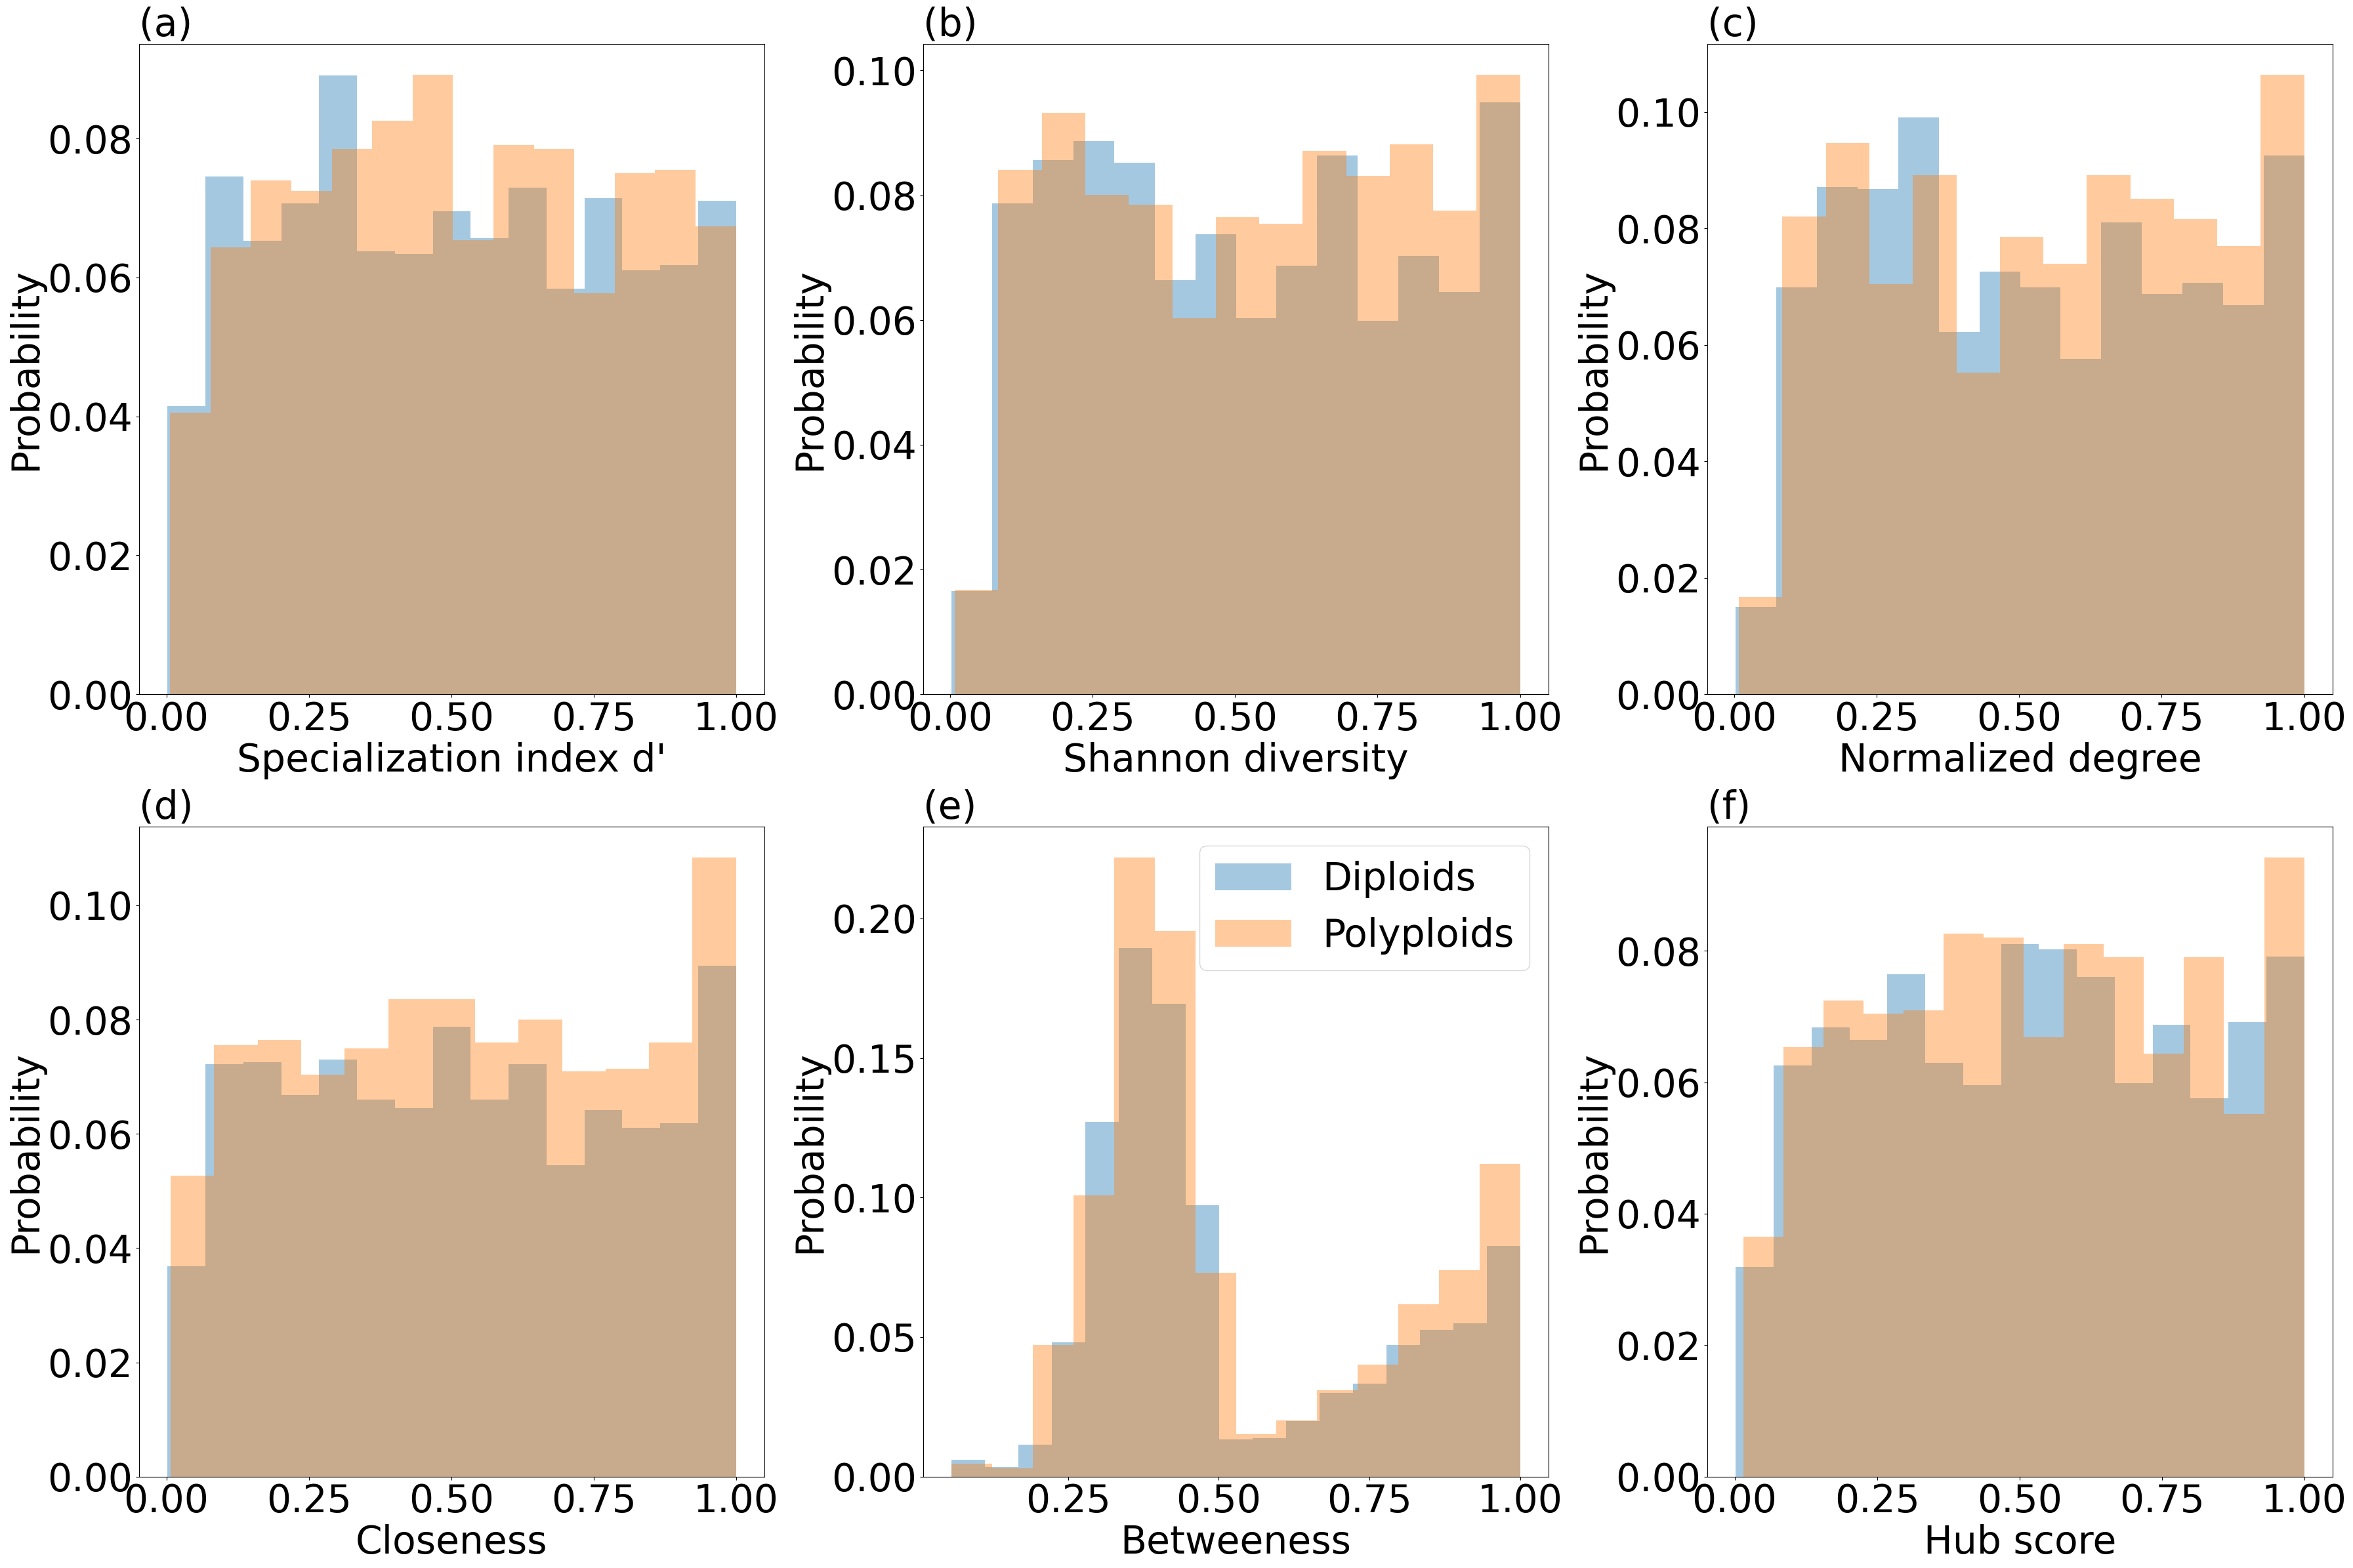

In [47]:
import seaborn as sns
plt.rcParams["patch.force_edgecolor"] = False
fontsize = 42
poly_color = "tab:orange"
di_color = "tab:blue"
alpha = 0.4

fig, ax = plt.subplots(figsize=(3*12, 2*12))
# fig.suptitle(f"Indices distribution across {features_by_ploidy.get_group('Polyploids').shape[0]:,} polyploids and {features_by_ploidy.get_group('Diploids').shape[0]:,} diploids", fontsize=fontsize)

ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2, fig=fig)
ax2 = plt.subplot2grid((2,6), (0,2), colspan=2, fig=fig)
ax3 = plt.subplot2grid((2,6), (0,4), colspan=2, fig=fig)
ax4 = plt.subplot2grid((2,6), (1,0), colspan=2, fig=fig)
ax5 = plt.subplot2grid((2,6), (1,2), colspan=2, fig=fig)
ax6 = plt.subplot2grid((2,6), (1,4), colspan=2, fig=fig)

sns.histplot(features_by_ploidy.get_group("Diploids")["standardized_d"], label="Diploids", color=di_color, ax=ax1, stat="probability", alpha=alpha, linewidth=0)
sns.histplot(features_by_ploidy.get_group("Polyploids")["standardized_d"], label="Polyploids", ax=ax1, color=poly_color, stat="probability", alpha=alpha, linewidth=0)
ax1.set_xlabel("Specialization index d'", fontsize=fontsize)
ax1.set_ylabel("Probability", fontsize=fontsize)
ax1.tick_params(axis='both', which='major', labelsize=fontsize)
ax1.tick_params(axis='both', which='minor', labelsize=fontsize)
ax1.set_title("(a)", loc="left", fontsize=fontsize)

sns.histplot(features_by_ploidy.get_group("Diploids")["standardized_partner.diversity"], label="Diploids", color=di_color, ax=ax2, stat="probability", alpha=alpha, linewidth=0)
sns.histplot(features_by_ploidy.get_group("Polyploids")["standardized_partner.diversity"], label="Polyploids", ax=ax2, color=poly_color, stat="probability",alpha=alpha, linewidth=0)
ax2.set_xlabel("Shannon diversity", fontsize=fontsize)
ax2.set_ylabel("Probability", fontsize=fontsize)
ax2.tick_params(axis='both', which='major', labelsize=fontsize)
ax2.tick_params(axis='both', which='minor', labelsize=fontsize)
ax2.set_title("(b)", loc="left", fontsize=fontsize)


sns.histplot(features_by_ploidy.get_group("Diploids")["standardized_normalised.degree"], label="Diploids", color=di_color, ax=ax3, stat="probability", alpha=alpha, linewidth=0)
sns.histplot(features_by_ploidy.get_group("Polyploids")["standardized_normalised.degree"], label="Polyploids", ax=ax3, color=poly_color, stat="probability", alpha=alpha, linewidth=0)
ax3.set_xlabel("Normalized degree", fontsize=fontsize)
ax3.set_ylabel("Probability", fontsize=fontsize)
ax3.tick_params(axis='both', which='major', labelsize=fontsize)
ax3.tick_params(axis='both', which='minor', labelsize=fontsize)
ax3.set_title("(c)", loc="left", fontsize=fontsize)

sns.histplot(features_by_ploidy.get_group("Diploids")["standardized_weighted.closeness"], label="Diploids", color=di_color, ax=ax4, stat="probability", alpha=alpha, linewidth=0)
sns.histplot(features_by_ploidy.get_group("Polyploids")["standardized_weighted.closeness"], label="Polyploids", ax=ax4, color=poly_color, stat="probability", alpha=alpha, linewidth=0)
ax4.set_xlabel("Closeness", fontsize=fontsize)
ax4.set_ylabel("Probability", fontsize=fontsize)
ax4.tick_params(axis='both', which='major', labelsize=fontsize)
ax4.tick_params(axis='both', which='minor', labelsize=fontsize)
ax4.set_title("(d)", loc="left", fontsize=fontsize)

sns.histplot(features_by_ploidy.get_group("Diploids")["standardized_weighted.betweenness"], label="Diploids", color=di_color, ax=ax5, stat="probability", alpha=alpha, linewidth=0)
sns.histplot(features_by_ploidy.get_group("Polyploids")["standardized_weighted.betweenness"], label="Polyploids", ax=ax5, color=poly_color, stat="probability", alpha=alpha, linewidth=0)
ax5.set_xlabel("Betweeness", fontsize=fontsize)
ax5.legend(prop={'size': fontsize})
ax5.set_ylabel("Probability", fontsize=fontsize)
ax5.tick_params(axis='both', which='major', labelsize=fontsize)
ax5.tick_params(axis='both', which='minor', labelsize=fontsize)
ax5.set_title("(e)", loc="left", fontsize=fontsize)


sns.histplot(features_by_ploidy.get_group("Diploids")["standardized_hubbiness_score"], label="Diploids", color=di_color, ax=ax6, stat="probability", alpha=alpha, linewidth=0)
sns.histplot(features_by_ploidy.get_group("Polyploids")["standardized_hubbiness_score"], label="Polyploids", ax=ax6, color=poly_color, stat="probability", alpha=alpha, linewidth=0)
ax6.set_xlabel("Hub score", fontsize=fontsize)
ax6.set_ylabel("Probability", fontsize=fontsize)
ax6.tick_params(axis='both', which='major', labelsize=fontsize)
ax6.tick_params(axis='both', which='minor', labelsize=fontsize)
ax6.set_title("(f)", loc="left", fontsize=fontsize)

fig.tight_layout()
fig.savefig(f"../../../data/figures/fig1_{'weighted' if do_weighted else 'binary'}.jpeg")

/tmp/ipykernel_7781/1359977466.py:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2, fig=fig)
/groups/itay_mayrose/halabikeren/miniconda3/envs/ppn/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


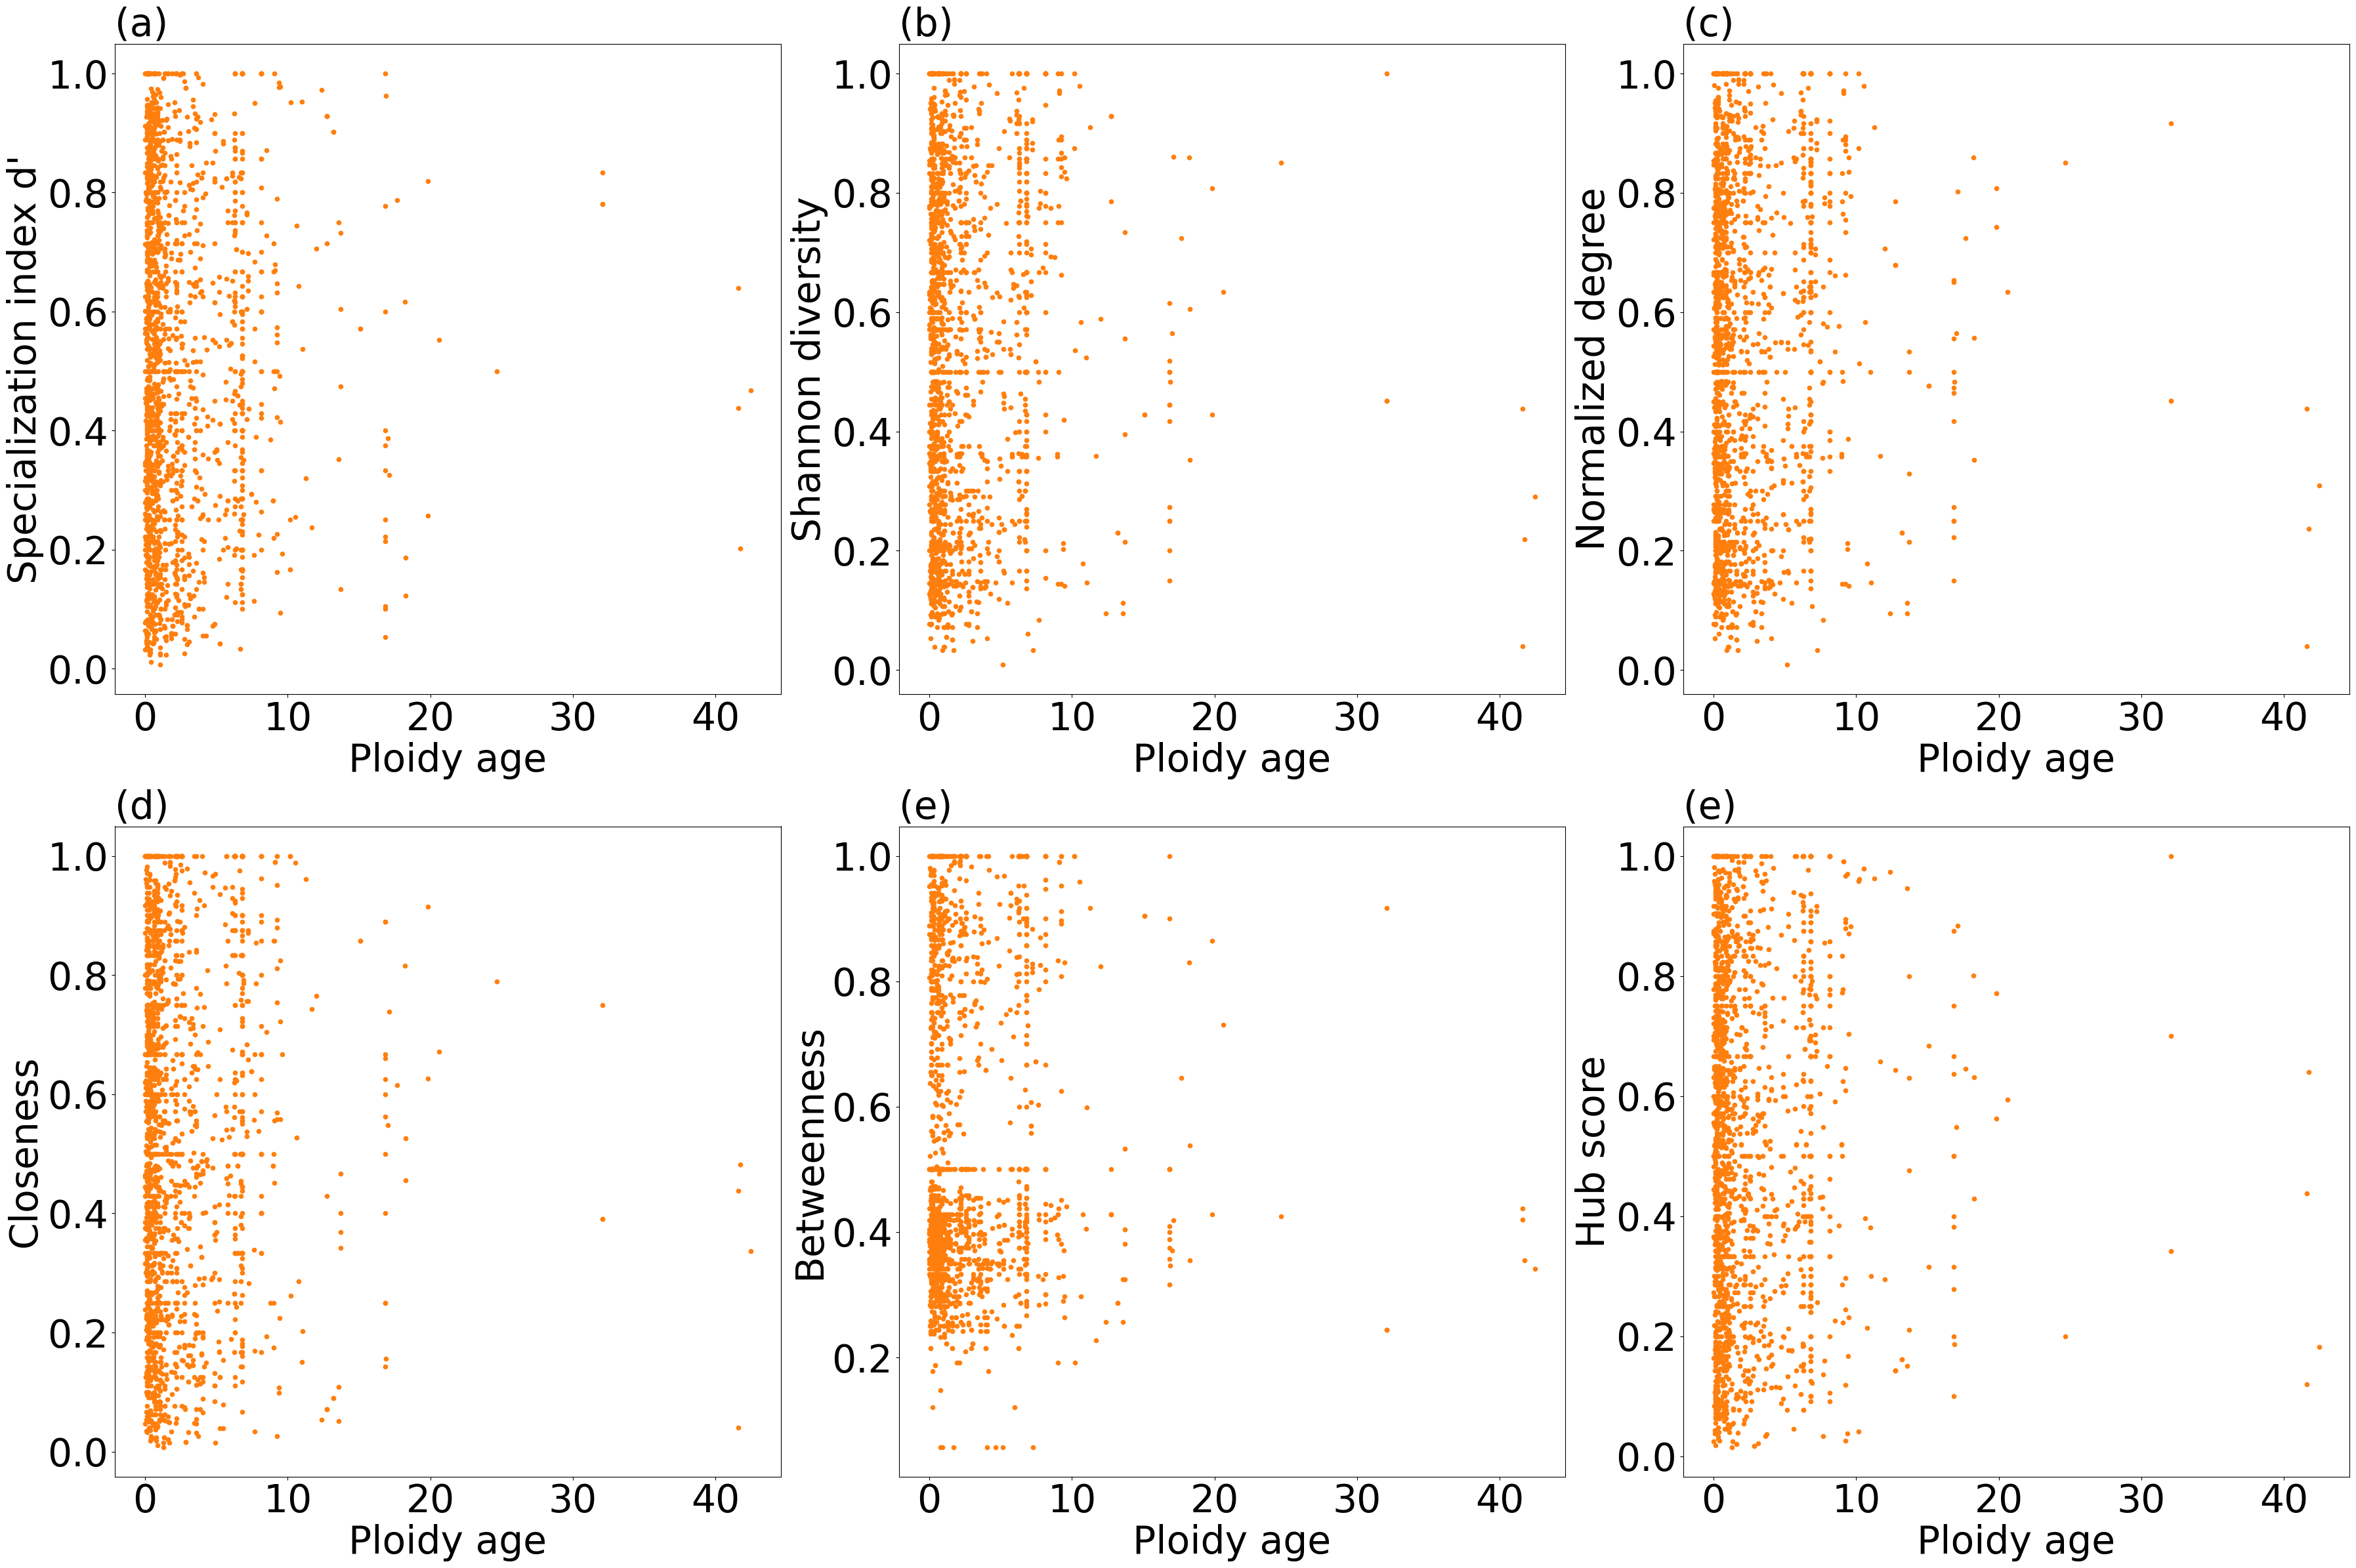

In [48]:
import seaborn as sns
plt.rcParams["patch.force_edgecolor"] = False
fontsize = 42
poly_color = "tab:orange"
di_color = "tab:blue"
alpha = 0.4

fig, ax = plt.subplots(figsize=(3*12, 2*12))
polyploids = features_by_ploidy.get_group("Polyploids")

ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2, fig=fig)
ax2 = plt.subplot2grid((2,6), (0,2), colspan=2, fig=fig)
ax3 = plt.subplot2grid((2,6), (0,4), colspan=2, fig=fig)
ax4 = plt.subplot2grid((2,6), (1,0), colspan=2, fig=fig)
ax5 = plt.subplot2grid((2,6), (1,2), colspan=2, fig=fig)
ax6 = plt.subplot2grid((2,6), (1,4), colspan=2, fig=fig)


polyploids.plot.scatter(x="ploidy_age", y="standardized_d", color=poly_color, ax=ax1)
ax1.set_ylabel("Specialization index d'", fontsize=fontsize)
ax1.set_xlabel("Ploidy age", fontsize=fontsize)
ax1.tick_params(axis='both', which='major', labelsize=fontsize)
ax1.set_title("(a)", loc="left", fontsize=fontsize)


polyploids.plot.scatter(x="ploidy_age", y="standardized_partner.diversity", color=poly_color, ax=ax2)
ax2.set_ylabel("Shannon diversity", fontsize=fontsize)
ax2.set_xlabel("Ploidy age", fontsize=fontsize)
ax2.tick_params(axis='both', which='major', labelsize=fontsize)
ax2.set_title("(b)", loc="left", fontsize=fontsize)


polyploids.plot.scatter(x="ploidy_age", y="standardized_normalised.degree", color=poly_color, ax=ax3)
ax3.set_ylabel("Normalized degree", fontsize=fontsize)
ax3.set_xlabel("Ploidy age", fontsize=fontsize)
ax3.tick_params(axis='both', which='major', labelsize=fontsize)
ax3.set_title("(c)", loc="left", fontsize=fontsize)


polyploids.plot.scatter(x="ploidy_age", y="standardized_weighted.closeness", color=poly_color, ax=ax4)
ax4.set_ylabel("Closeness", fontsize=fontsize)
ax4.set_xlabel("Ploidy age", fontsize=fontsize)
ax4.tick_params(axis='both', which='major', labelsize=fontsize)
ax4.set_title("(d)", loc="left", fontsize=fontsize)


polyploids.plot.scatter(x="ploidy_age", y="standardized_weighted.betweenness", color=poly_color, ax=ax5)
ax5.set_ylabel("Betweenness", fontsize=fontsize)
ax5.set_xlabel("Ploidy age", fontsize=fontsize)
ax5.tick_params(axis='both', which='major', labelsize=fontsize)
ax5.set_title("(e)", loc="left", fontsize=fontsize)


polyploids.plot.scatter(x="ploidy_age", y="standardized_hubbiness_score", color=poly_color, ax=ax6)
ax6.set_ylabel("Hub score", fontsize=fontsize)
ax6.set_xlabel("Ploidy age", fontsize=fontsize)
ax6.tick_params(axis='both', which='major', labelsize=fontsize)
ax6.set_title("(e)", loc="left", fontsize=fontsize)


fig.tight_layout()
fig.savefig(f"../../../data/figures/fig_pl_age_{'weighted' if do_weighted else 'binary'}.jpeg")

In [49]:
from scipy.stats import ks_2samp

for feature in relevant_features:
    if not "standardized" in feature:
        continue
    dres = ks_2samp(features_by_ploidy.get_group("Diploids")[feature], features_by_ploidy.get_group("Polyploids")[feature])
    if dres.pvalue <= 0.05:
        print(f"# KS test for comparison of {feature} distribution across diploids and polyploids = {dres}")

# KS test for comparison of standardized_partner.diversity distribution across diploids and polyploids = KstestResult(statistic=0.046205510344151386, pvalue=0.015905339955403556)
# KS test for comparison of standardized_d distribution across diploids and polyploids = KstestResult(statistic=0.050143804948197535, pvalue=0.006757955556837982)
# KS test for comparison of standardized_normalised.degree distribution across diploids and polyploids = KstestResult(statistic=0.04997221949864366, pvalue=0.007024940542692194)


# add another data path limited to networks with available geo data

In [71]:
final_features_with_classification = pd.read_csv(processed_data_path)
networks_metadata = pd.read_csv(networks_metadata_path).rename(columns={"species_richness.y": "species_richness"})

In [72]:
final_features_with_classification["network_index"] = final_features_with_classification.network_id.apply(lambda x: int(x.split("_")[-1]))

In [73]:
networks_metadata[["network_type", "network_index"] + bioclim_columns].head()

,network_type,network_index,Latitude,Longitude,EcoRegion,Annual Mean Temperature,Mean Diurnal Range (Mean of monthly (max temp - min temp)),Isothermality (BioClim_2/BioClim_7) (×100),Temperature Seasonality (standard deviation ×100),Max Temperature of Warmest Month,...,Mean Temperature of Coldest Quarter,Annual Precipitation,Precipitation of Wettest Month,Precipitation of Driest Month,Precipitation Seasonality (Coefficient of Variation),Precipitation of Wettest Quarter,Precipitation of Driest Quarter,Precipitation of Warmest Quarter,Precipitation of Coldest Quarter,species_richness
0,binary,77,-41.077069,-71.525206,60404.0,6.808094,6.808094,6.808094,6.808094,6.808094,...,6.808094,6.808094,6.808094,6.808094,6.808094,6.808094,6.808094,6.808094,6.808094,180.0
1,binary,78,28.377248,129.493741,40170.0,20.821884,20.821884,20.821884,20.821884,20.821884,...,20.821884,20.821884,20.821884,20.821884,20.821884,20.821884,20.821884,20.821884,20.821884,147.0
2,binary,79,-4.666667,55.433330,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,binary,80,-4.666667,55.433330,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,binary,81,-4.666667,55.433330,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [74]:
print(f"# networks with features = {final_features_with_classification[['network_type', 'network_index']].drop_duplicates().shape[0]:,}") 

# networks with features = 513


In [75]:
bioclim_columns = ['Latitude', 'Longitude', 'EcoRegion','Annual Mean Temperature',
                   'Mean Diurnal Range (Mean of monthly (max temp - min temp))',
                   'Isothermality (BioClim_2/BioClim_7) (×100)',
                   'Temperature Seasonality (standard deviation ×100)',
                   'Max Temperature of Warmest Month', 'Min Temperature of Coldest Month',
                   'Temperature Annual Range (BioClim_5-BioClim_6)',
                   'Mean Temperature of Wettest Quarter',
                   'Mean Temperature of Driest Quarter',
                   'Mean Temperature of Warmest Quarter',
                   'Mean Temperature of Coldest Quarter', 'Annual Precipitation',
                   'Precipitation of Wettest Month', 'Precipitation of Driest Month',
                   'Precipitation Seasonality (Coefficient of Variation)',
                   'Precipitation of Wettest Quarter', 'Precipitation of Driest Quarter',
                   'Precipitation of Warmest Quarter', 'Precipitation of Coldest Quarter',
                   'species_richness']

In [79]:
final_features_with_classification = final_features_with_classification.merge(networks_metadata[["network_type", "network_index"] + bioclim_columns], on=["network_type", "network_index"], how="left")
final_features_with_classification = final_features_with_classification[[c for c in final_features_with_classification.columns if "Unnamed" not in c]]
final_features_with_classification.notna().sum() / final_features_with_classification.shape[0]

original_name                                                 1.000000
Plant                                                         1.000000
network_id                                                    1.000000
partner.diversity                                             1.000000
d                                                             1.000000
normalised.degree                                             1.000000
weighted.betweenness                                          1.000000
weighted.closeness                                            1.000000
hubbiness_score                                               1.000000
standardized_partner.diversity                                1.000000
standardized_d                                                1.000000
standardized_normalised.degree                                1.000000
standardized_weighted.betweenness                             1.000000
standardized_weighted.closeness                               1.000000
standa

In [82]:
relevant_final_features_with_classification = final_features_with_classification.dropna(subset=["EcoRegion"])
print(f"# networks with available ecoregion = {len(relevant_final_features_with_classification.network_id.unique()):,}")                        

# networks with available ecoregion = 171


In [87]:
relevant_final_features_with_classification.to_csv(processed_data_w_geo_path, index=False)